In [1]:
# importing libraries

In [1]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, optimizers, callbacks
from PIL import Image
import requests
from io import BytesIO
from tensorflow.keras.models import load_model


2024-03-08 19:08:44.387043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Loading the data

In [2]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Put Colab in the context of this challenge
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense')

In [5]:
!pwd


/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense


In [6]:
!ls

dummy_model.h5	good_model.h5  notebooks  raw_data  README.md


In [8]:
!ls raw_data

sign_asl


In [9]:
def load_asl_data():

    local_path = 'data/sign_asl/asl_alphabet_train/asl_alphabet_train'
    data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_train/asl_alphabet_train'
    classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:3001]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((50, 50))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_asl_data()


100%|██████████| 3000/3000 [01:15<00:00, 39.56it/s] 


In [13]:
print(X_train.shape, X_val.shape, X_test.shape)

(51300, 50, 50, 3) (16200, 50, 50, 3) (13500, 50, 50, 3)


In [14]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 2 .Visualization

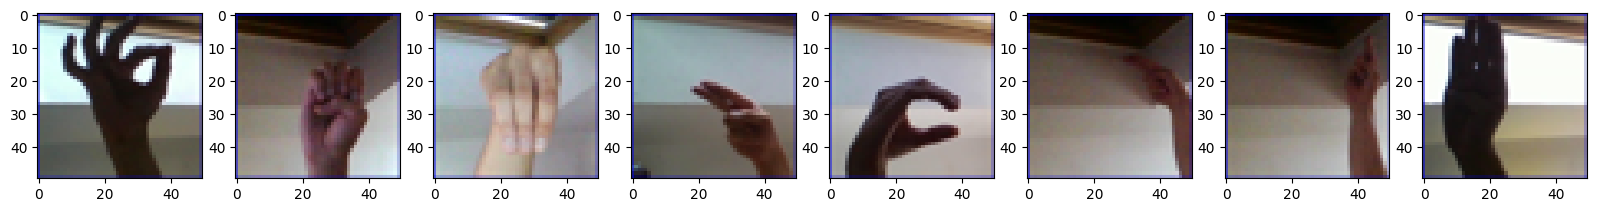

In [15]:
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])

# 3. CNN Models

## 3.1 Dummy model

In [ ]:
def dummy_model():
  input_shape= (50,50,3)
  model = Sequential()

  model.add(layers.Rescaling(1./255, input_shape = input_shape))
  model.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

  model.add(layers.Flatten())

  # Here we flatten our data

  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.2))


# prediction layer
  model.add(layers.Dense(27, activation="sigmoid"))

# compiling model
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])


  return model

In [ ]:
dummy_model= dummy_model()
dummy_model.summary()

In [ ]:
MODEL = "dummy_model"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
%%time
history = dummy_model.fit(X_train, y_train,
        epochs=15,
        validation_data= (X_val, y_val),
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])


In [17]:
model_dummy = load_model("dummy_model.h5")

In [18]:
# Evaluation:
res = model_dummy.evaluate(X_test, y_test)
res

422/422 [==============================] - 4s 4ms/step - loss: 8.9945e-05 - accuracy: 1.0000


[8.994482777779922e-05, 1.0]

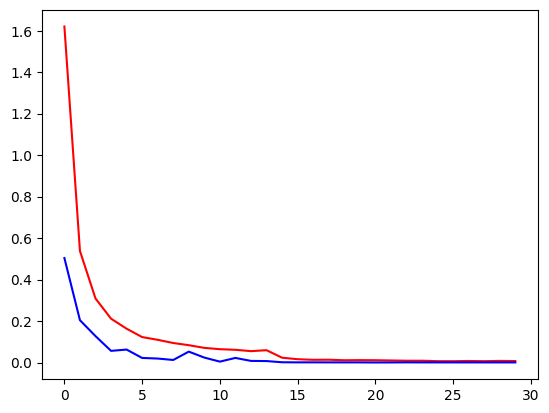

In [ ]:
plt.plot(history.history["loss"], 'r')
plt.plot(history.history["val_loss"], 'b')


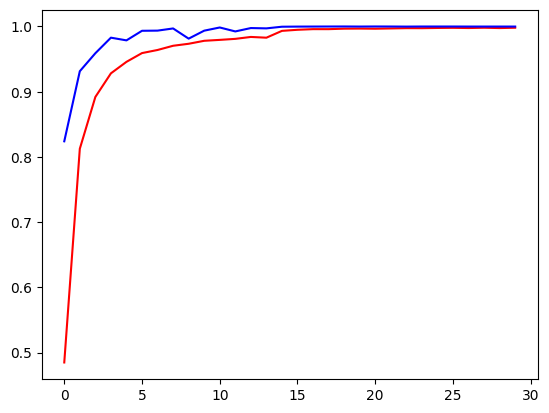

In [ ]:
plt.plot(history.history["accuracy"], 'r')
plt.plot(history.history["val_accuracy"], 'b')

### 3.1.1 prediction

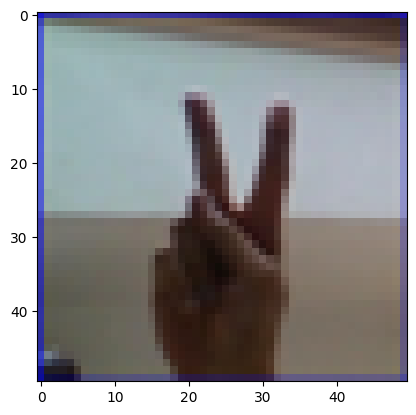

In [19]:

test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[1])
image = Image.open(path)
image = image.resize((50, 50))
plt.imshow(image)

In [20]:
path = os.path.join(test_data_path, files[2])
path

'/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test/I_test.jpg'

In [21]:
img = np.array(image)
img = img.reshape((-1, 50, 50, 3))
res = model_dummy.predict(img)
res

1/1 [==============================] - 0s 424ms/step


array([[1.7613999e-11, 3.0467021e-05, 6.3641770e-23, 3.2156370e-16,
        8.2193735e-13, 5.3738422e-08, 8.7576145e-01, 7.7989562e-06,
        1.9172280e-03, 1.0000000e+00, 2.9417595e-08, 3.7067034e-03,
        3.6569082e-14, 1.1270932e-08, 2.3881523e-18, 8.0801131e-36,
        9.9580020e-01, 3.8361391e-24, 6.1400124e-23, 4.0476584e-14,
        9.7665137e-01, 9.8343706e-01, 1.2591160e-18, 1.5326549e-16,
        2.1030546e-19, 3.0672962e-22, 8.0338665e-05]], dtype=float32)

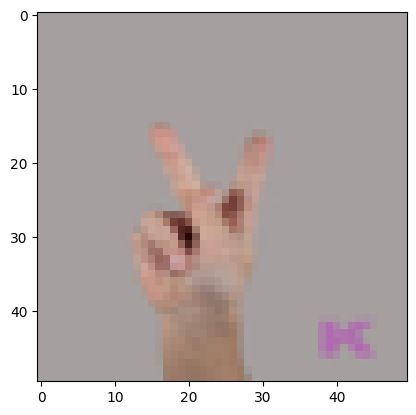

In [22]:
url= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((50, 50))
plt.imshow(img)


In [23]:
img2 = np.array(img)
img2 = img2.reshape((-1, 50, 50, 3))
res = model_dummy.predict(img2)
res

1/1 [==============================] - 0s 17ms/step


array([[2.5028975e-03, 6.9574617e-09, 0.0000000e+00, 0.0000000e+00,
        5.4275591e-24, 4.7517035e-28, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.5148287e-11,
        9.4364087e-15, 0.0000000e+00, 4.1917568e-24, 5.7326226e-24,
        3.3157696e-03, 1.1555747e-08, 0.0000000e+00, 2.0555850e-33,
        0.0000000e+00, 3.0552227e-10, 0.0000000e+00, 1.6147561e-36,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [29]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)


['nothing']


## 3.2 Good model

In [24]:
def good_model():
  input_shape= (50,50,3)
  model = Sequential()

  model.add(layers.Rescaling(1./255, input_shape = input_shape))
  model.add(layers.Conv2D(filters = 32, kernel_size = (7,7), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 64, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 128, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

  model.add(layers.Conv2D(filters = 512, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same"))

  model.add(layers.Conv2D(filters = 1024, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same"))

  model.add(layers.Flatten())

  # Here we flatten our data

  model.add(layers.Dense(512, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())

  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())

  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())

# prediction layer
  model.add(layers.Dense(27, activation="sigmoid"))

# compiling model
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])


  return model

In [25]:
model_good = good_model()
model_good.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        4736      
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 64)        2

In [26]:


MODEL = "good_model"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [27]:
%%time
history = model_good.fit(X_train, y_train,
        epochs=20,
        validation_data= (X_val, y_val),
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])


Epoch 1/20
1604/1604 [==============================] - ETA: 0s - loss: 1.2910 - accuracy: 0.6053

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1604/1604 [==============================] - 51s 26ms/step - loss: 1.2910 - accuracy: 0.6053 - val_loss: 2.2486 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 2/20
1604/1604 [==============================] - 37s 23ms/step - loss: 0.2582 - accuracy: 0.9234 - val_loss: 0.2406 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 3/20
1604/1604 [==============================] - 37s 23ms/step - loss: 0.1488 - accuracy: 0.9559 - val_loss: 0.2043 - val_accuracy: 0.9344 - lr: 0.0010
Epoch 4/20
1604/1604 [==============================] - 35s 22ms/step - loss: 0.0861 - accuracy: 0.9757 - val_loss: 0.6023 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 5/20
1604/1604 [==============================] - 37s 23ms/step - loss: 0.0628 - accuracy: 0.9824 - val_loss: 0.0677 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/20
1604/1604 [==============================] - 37s 23ms/step - loss: 0.0596 - accuracy: 0.9834 - val_loss: 0.0264 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 7/20
1604/1604 [==============================] - 3

### 3.2.1 prediction

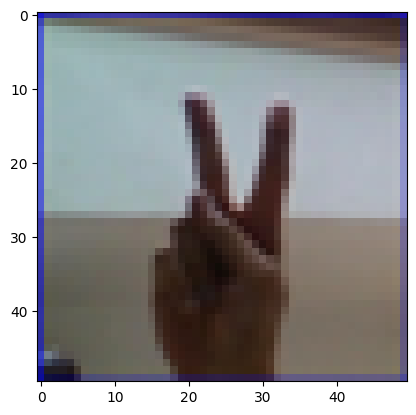

In [30]:
test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/raw_data/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[1])
image = Image.open(path)
image = image.resize((50, 50))
plt.imshow(image)

In [32]:
img = np.array(image)
img = img.reshape((-1, 50, 50, 3))
res = model_good.predict(img)
res

1/1 [==============================] - 1s 513ms/step


array([[9.7288394e-01, 6.2931657e-01, 2.7842805e-01, 2.5322703e-01,
        7.3229350e-02, 7.8490877e-01, 8.7142390e-01, 9.0618086e-01,
        9.5436317e-01, 1.0000000e+00, 8.8863778e-01, 5.3122115e-01,
        2.6026350e-01, 9.0381004e-02, 1.6711089e-04, 4.1118208e-01,
        9.8696125e-01, 1.4318649e-03, 3.2329306e-02, 2.8647441e-01,
        9.9739408e-01, 9.6363670e-01, 3.1419963e-02, 8.4232837e-02,
        1.1376056e-01, 9.5310397e-02, 7.8518018e-03]], dtype=float32)

In [33]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

['K']


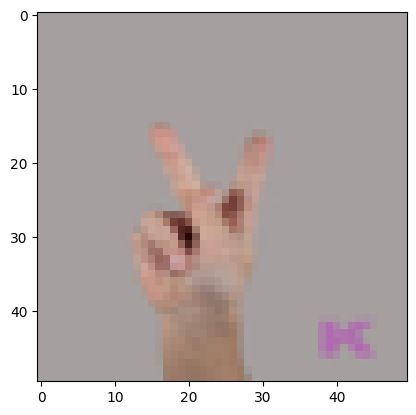

In [34]:
url= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((50, 50))
plt.imshow(img)


In [36]:
img2 = np.array(img)
img2 = img2.reshape((-1, 50, 50, 3))
res = model_good.predict(img2)
res

1/1 [==============================] - 0s 19ms/step


array([[0.45837435, 0.0191789 , 0.8735937 , 0.74377763, 0.08869368,
        0.49061754, 0.12937957, 0.01885567, 0.11070115, 0.8708485 ,
        0.97524613, 0.42136705, 0.8970884 , 0.9816745 , 0.11446963,
        0.41618937, 0.13643913, 0.7872582 , 0.9950429 , 0.3039112 ,
        0.99668556, 0.8353337 , 0.9387479 , 0.53848034, 0.7555547 ,
        0.18098977, 0.9020709 ]], dtype=float32)

In [37]:
# this is how to convert the probabilities to the letter from prediction
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)

['V']


## 3.3 Model with data augmentation

### 3.3.1 prediction

## 3.4 Model with transfer learning

In [ ]:
# first load your VGG 16 model
def load_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model
model = load_model()

In [ ]:
# make sure to NOT train it
def set_nontrainable_layers(model):

    model.trainable = False

    return model
model = set_nontrainable_layers(model)

In [ ]:
# Of course you can add layers to the pre trained:
def add_last_layers(model):

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [ ]:

model = add_last_layers(model)

### 3.4.1 prediction

## 3.5 Model with mix of data augmnetation and transfer learning

### 3.5.1 prediction

# 4. Predicion function (chaging the probabilities to a letter)